## Delivery Transaction Data Preprocessing

#### Make sure the latest module changes are referenced

In [239]:
# make sure the latest module changes are referenced
%load_ext autoreload
%autoreload 2
import data_preprocessing as dp
import importlib
importlib.reload(dp)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'data_preprocessing' from '/Users/maungthura2024/Documents/GitHub/translogi-delivery-optimizer/app/data_preprocessing.py'>

#### Retrieve Delivery Transactions from MySQL

In [240]:
dp.init()
data = dp.retrieve_raw_data('sql.json')

Connected to MySQL successfully!
Successfully retrieved the data.
MySQL connection closed.


#### Examine the first few rows and dataset summary

In [241]:
data.head(), data.info(), data.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype          
---  ------           --------------  -----          
 0   order_id         43739 non-null  object         
 1   agent_age        43739 non-null  int64          
 2   agent_rating     43685 non-null  float64        
 3   store_latitude   43739 non-null  object         
 4   store_longitude  43739 non-null  object         
 5   drop_latitude    43739 non-null  object         
 6   drop_longitude   43739 non-null  object         
 7   order_date       43739 non-null  object         
 8   order_time       43648 non-null  timedelta64[ns]
 9   pickup_time      43739 non-null  timedelta64[ns]
 10  weather          43648 non-null  object         
 11  traffic          43648 non-null  object         
 12  vehicle          43739 non-null  object         
 13  area             43739 non-null  object         
 14  delivery_time    43739

(        order_id  agent_age  agent_rating store_latitude store_longitude  \
 0  aaar186826409         38           5.0    23.33301700     85.31720000   
 1  aabo036315307         37           4.5    19.12008300     72.90738500   
 2  aabo151954572         39           4.7    26.89231200     75.80689600   
 3  aabt975198794         20           4.5    12.31107200     76.65487800   
 4  aabx020665819         38           5.0    22.72574800     75.89849700   
 
   drop_latitude drop_longitude  order_date      order_time     pickup_time  \
 0   23.39301700    85.37720000  2022-03-26 0 days 20:20:00 0 days 20:30:00   
 1   19.16008300    72.94738500  2022-03-24 0 days 13:45:00 0 days 14:00:00   
 2   27.00231200    75.91689600  2022-03-23 0 days 18:35:00 0 days 18:50:00   
 3   12.38107200    76.72487800  2022-03-14 0 days 17:50:00 0 days 18:00:00   
 4   22.85574700    76.02849700  2022-04-04 0 days 18:55:00 0 days 19:05:00   
 
   weather  traffic      vehicle            area  delivery_t

#### Find columns with missing values

In [242]:
dp.detect_missing_values(data)

Columns with Missing Values:
agent_rating    54
order_time      91
weather         91
traffic         91
dtype: int64


In [243]:
# Checking outliers in numerical columns by using statistical Interquartile Range (IQR) method.
for col in ['agent_age', 'agent_rating', 'delivery_time']:
    dp.detect_outliers_iqr(data, col)

Column: agent_age
Lower Bound: 10.0, Upper Bound: 50.0
Number of Outliers: 0
--------------------------------------------------
Column: agent_rating
Lower Bound: 3.8999999999999995, Upper Bound: 5.500000000000001
Number of Outliers: 1223
--------------------------------------------------
Column: delivery_time
Lower Bound: -15.0, Upper Bound: 265.0
Number of Outliers: 79
--------------------------------------------------


#### Visualize the Outliers

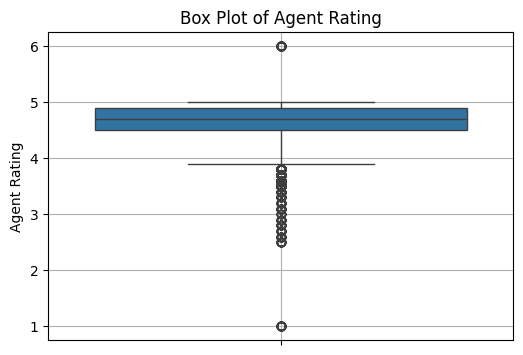

In [244]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.boxplot(y=data['agent_rating'])
plt.title("Box Plot of Agent Rating")
plt.ylabel("Agent Rating")
plt.grid(True)
plt.show()

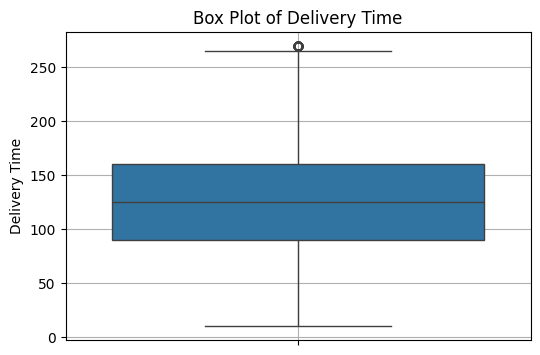

In [245]:
plt.figure(figsize=(6, 4))
sns.boxplot(y=data['delivery_time'])
plt.title("Box Plot of Delivery Time")
plt.ylabel("Delivery Time")
plt.grid(True)
plt.show()


#### Handle Missing Values and Outliers
By looking at the total number of outliers in each 'agent_rating' and 'delivery_time' columns, I decided not to clip the outliers in both columns as I expect those outliers will give me some valuable insights.

In [246]:
dp.handle_missing_values(data)
# dp.handle_outliers(data)

#### Normalize geolocation data (latitude, longitude)

In [247]:
dp.normalize_columns(data, ['store_latitude', 'store_longitude', 'drop_latitude', 'drop_longitude'])

#### Create Average Delivery Time by Area

In [248]:
data['area'].unique()

array(['Metropolitian ', 'Urban ', 'Other', 'Semi-Urban '], dtype=object)

In [249]:
dp.trim_string_values(data, 'area')

In [250]:
data['area'].unique()

array(['Metropolitian', 'Urban', 'Other', 'Semi-Urban'], dtype=object)

In [251]:
dp.add_average_x_by_y(data, 'delivery_time', 'area', 'avg_delivery_time_by_area')

#### Impact of traffic and weather on delivery time.

In [252]:
data['traffic'].unique()

array(['Jam ', 'High ', 'Medium ', 'Low '], dtype=object)

In [253]:
dp.trim_string_values(data, 'traffic')

In [254]:
data['traffic'].unique()

array(['Jam', 'High', 'Medium', 'Low'], dtype=object)

In [255]:
data['weather'].unique()

array(['Cloudy', 'Windy', 'Fog', 'Sunny', 'Stormy', 'Sandstorms'],
      dtype=object)

In [256]:
dp.add_average_x_by_y_list(data, 'delivery_time', ['traffic', 'weather'], 'avg_delivery_time_by_traffic_and_weather')

#### Vehicle capacity utilization

##### Get all types of vehicles

In [257]:
data['vehicle'].unique()

array(['motorcycle ', 'van', 'scooter ', 'bicycle '], dtype=object)

In [258]:
dp.trim_string_values(data, 'vehicle')

In [259]:
data['vehicle'].unique()

array(['motorcycle', 'van', 'scooter', 'bicycle'], dtype=object)

##### Map arbitrary vehicle capacities to utilization 

In [260]:
vehicle_capacity = {'bicycle': 0.4, 'scooter': 0.8, 'motorcycle': 1, 'van': 6}
dp.add_vehicle_capacity_utilization(data, vehicle_capacity, 'vehicle_capacity_utilization')

##### Check the dataframe with newly added features

In [261]:
data.head()

,order_id,agent_age,agent_rating,store_latitude,store_longitude,drop_latitude,drop_longitude,order_date,order_time,pickup_time,weather,traffic,vehicle,area,delivery_time,category,avg_delivery_time_by_area,avg_delivery_time_by_traffic_and_weather,vehicle_capacity_utilization
0,aaar186826409,38,5.0,0.877363,0.982374,0.753220,0.964019,2022-03-26,0 days 20:20:00,0 days 20:30:00,Cloudy,Jam,motorcycle,Metropolitian,145,Cosmetics,129.702459,174.584473,145.0
1,aabo036315307,37,4.5,0.809211,0.912183,0.616868,0.823654,2022-03-24,0 days 13:45:00,0 days 14:00:00,Windy,High,motorcycle,Urban,140,Jewelry,109.434520,128.727273,140.0
2,aabo151954572,39,4.7,0.934941,0.928583,0.869484,0.857187,2022-03-23,0 days 18:35:00,0 days 18:50:00,Fog,Medium,motorcycle,Metropolitian,210,Sports,129.702459,132.194661,210.0
3,aabt975198794,20,4.5,0.699063,0.933379,0.398500,0.866312,2022-03-14,0 days 17:50:00,0 days 18:00:00,Sunny,Medium,motorcycle,Metropolitian,80,Toys,129.702459,96.020821,80.0
4,aabx020665819,38,5.0,0.867539,0.929101,0.735914,0.858448,2022-04-04,0 days 18:55:00,0 days 19:05:00,Cloudy,Medium,motorcycle,Metropolitian,195,Pet Supplies,129.702459,136.680720,195.0


In [262]:
data.isnull().sum()

order_id                                    0
agent_age                                   0
agent_rating                                0
store_latitude                              0
store_longitude                             0
drop_latitude                               0
drop_longitude                              0
order_date                                  0
order_time                                  0
pickup_time                                 0
weather                                     0
traffic                                     0
vehicle                                     0
area                                        0
delivery_time                               0
category                                    0
avg_delivery_time_by_area                   0
avg_delivery_time_by_traffic_and_weather    0
vehicle_capacity_utilization                0
dtype: int64

##### Remove the unique order id column

In [263]:
data['order_id'].nunique()

43739

In [264]:
len(data)

43739

In [265]:
data = data.drop('order_id', axis=1) 

#### Save the preprocessed delivery transaction data back into MySQL

In [266]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 18 columns):
 #   Column                                    Non-Null Count  Dtype          
---  ------                                    --------------  -----          
 0   agent_age                                 43739 non-null  int64          
 1   agent_rating                              43739 non-null  float64        
 2   store_latitude                            43739 non-null  float64        
 3   store_longitude                           43739 non-null  float64        
 4   drop_latitude                             43739 non-null  float64        
 5   drop_longitude                            43739 non-null  float64        
 6   order_date                                43739 non-null  object         
 7   order_time                                43739 non-null  timedelta64[ns]
 8   pickup_time                               43739 non-null  timedelta64[ns]
 9   weather          

In [267]:
# Convert timedelta to string in HH:MM:SS format
data['order_time'] = data['order_time'].apply(lambda x: str(x).split()[-1])
data['pickup_time'] = data['pickup_time'].apply(lambda x: str(x).split()[-1])

In [268]:
dp.save_preprocessed_data(data, 'sql.json')

Connected to MySQL successfully!
Preprocessed data inserted successfully into MySQL database.
MySQL connection closed.
